<span style='font-family: Times; font-size: 2em;'>MIMIC v. 2.2 Database Heart Failure Filtering</span>


**Veronica Ramirez-Lopera** 

### Objectives: 
#### Main objective:
To filter the patients with heart failure diagnosis for the analysis 

### **Table of contents**
- [Introduction](#introduction)
- [Package Requirements](#package_requirements)
- [Data importing](#importing)

Introduction

    1.1 Overview of MIMIC-IV Database
    1.2 Objectives of the Study
    1.3 Scope of the Analysis

Package Requirements

    2.1 Python Libraries and Dependencies
    2.2 Data Access via BigQuery
    2.3 Handling of CSV Data Files

Data Importing

    3.1 Dataset Structure
    3.2 Key Fields: Subject ID, Admission Type, ECG Data
    3.3 Data Loading and Preprocessing

Data Filtering and Patient Selection

    4.1 Exclusion Criteria: Non-Heart Failure Diagnoses
    4.2 Heart Failure ICD Codes (ICD-9 & ICD-10)
    4.3 Final Dataset: Patients with ECG Data and Heart Failure Diagnoses

Exploratory Data Analysis (EDA)

    5.1 Demographic Analysis
        5.1.1 Age Distribution
        5.1.2 Gender Distribution
        5.1.3 Race Distribution
    5.2 Hospitalization Analysis
        5.2.1 Length of Stay
        5.2.2 Admissions per Patient
    5.3 Mortality Analysis
        5.3.1 Survival Status
        5.3.2 Last Hospitalization Before Death

Statistical Analysis

    6.1 Shapiro-Wilks Test for Normality
    6.2 Descriptive Statistics
    6.3 Visualizing Data Distributions


Conclusion and Recommendations

    10.1 Summary of Key Findings
    10.2 Implications for Clinical Decision Support
    10.3 Recommendations for Future Research

References




## Introduction <a name='introduction'></a>
Here, I will filter the data to include patients according to the following criteria:
- Heart failure as one of their diagnosis 
- At least one admission 
- At least one ECG

We will get, as outputs in a csv format for our future analysis:
- icd_merged = All the hosp patients with their diagnosis. 
- admissions_icd = All the patients with an ecg and at least one admission with their ICD codes and diagnoses included. 


## Package requirements <a name='package_requirements'></a>

Notes: 

1- You need to install gcloud if you haven't already. Alternatively, you can use the provided csv files that contain the data.


In [1]:

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro
import wfdb
import scipy.signal as signal
import torch
import os
from lifelines import KaplanMeierFitter


# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 

# Construct a BigQuery client
client = bigquery.Client()

In [2]:
# Load the admissions data from the CSV file, extracted from Big Query in MIMIC - GENERAL ANNALISIS

'''
Since running the query is time-consuming, I will save the data to a CSV file and load it from there. 
This approach will also help avoid additional costs and allow for more efficient work.
'''

path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\new_admissions.csv'
admissions = pd.read_csv(path)

patients_path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\patients.csv'
patients = pd.read_csv(patients_path)


# Data filtering and visualization <a name='filtering'></a>

At this point, we have a dataset containing all patients who were hospitalized at least once, regardless of their diagnosis. Our goal now is to determine the number of hospitalizations for each patient and the number of ECGs recorded during each hospitalization.

In [3]:
# First, lets drop any hospitalization that does not have an ecg 
'''
We will drop any hospitalization that does not have an ECG, as the purpose of this report is to 
analyze whether there is enough data to analyze the dynamic changes in the heart during 
hospitalizations, and to create a model that can predict the outcome of a patient based on their
ECG data. 

'''

admissions = admissions.dropna(subset=['path'])                                                      # Drop rows with missing ECG paths
patients = patients.dropna(subset=['path'])     

In [4]:

# Lets count the amount of unique patients with at least one ECG and how many are dead or alive
unique_count = admissions['subject_id'].nunique()
dead_counts = patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, that have an ECG and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')



There are 82213 unique patients in the admissions data, that have an ECG and:
13413 are dead.
45571 are alive.


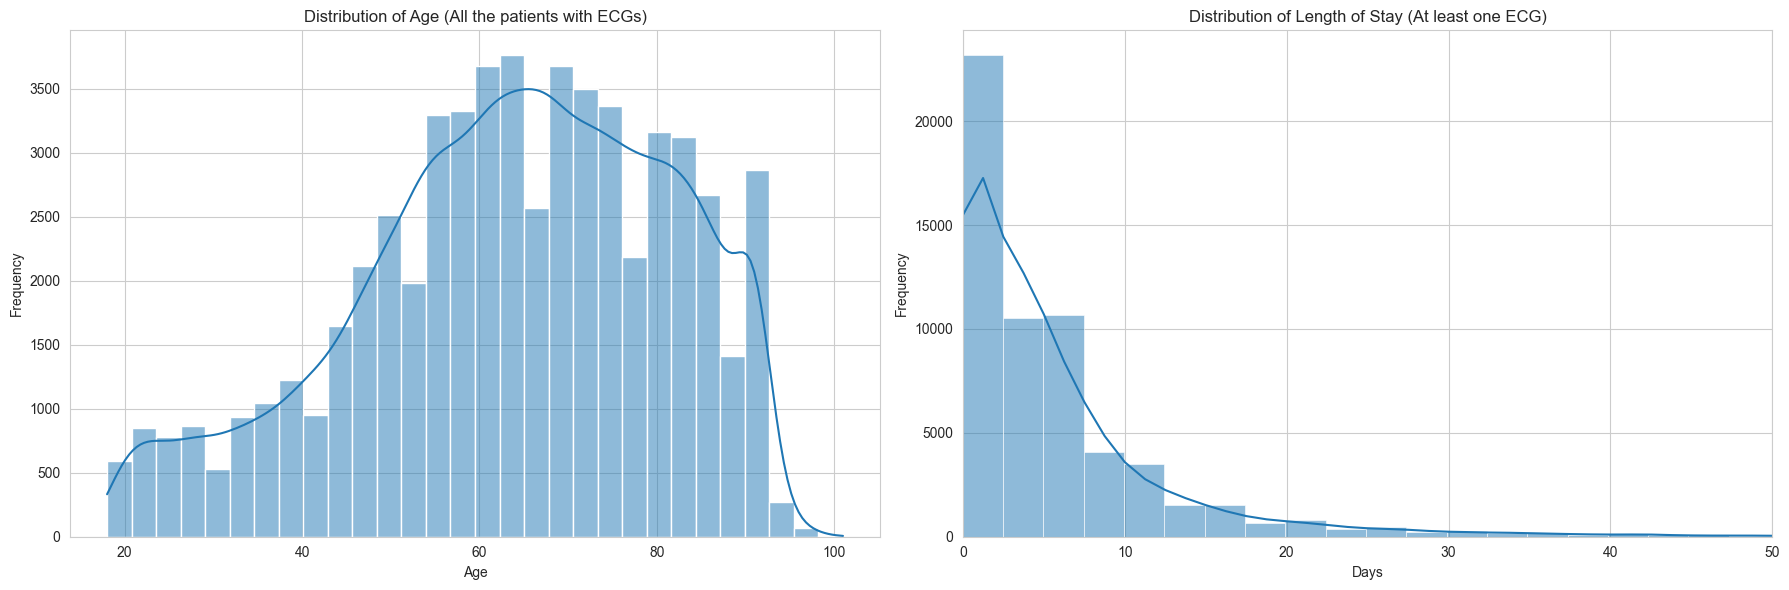

In [5]:
# Lets visualize the demographic data (patients that have at least one admission)
'''
Having at least one admission is a requirement to later visualize the diagnosis data.
'''

# Set the style of the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age (All the patients with ECGs)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay (At least one ECG)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [14]:
patients['age'].median()


65.0

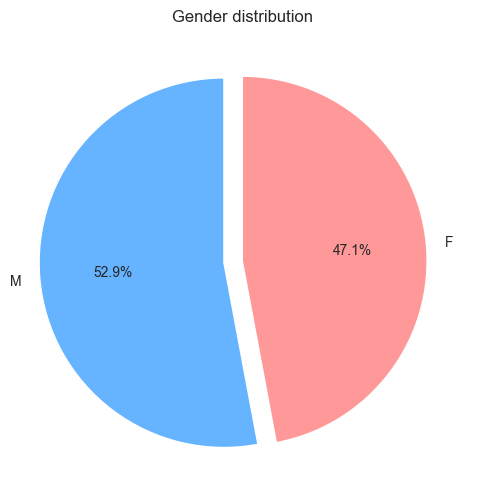

In [6]:
# Now lets plot the gender distribution

plt.figure(figsize=(6, 6))
patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
shadow=False, colors = ['#66b3ff', '#ff9999'])
plt.title('Gender distribution')
plt.ylabel('')
plt.show()

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\3010368775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='pastel')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\3010368775.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')


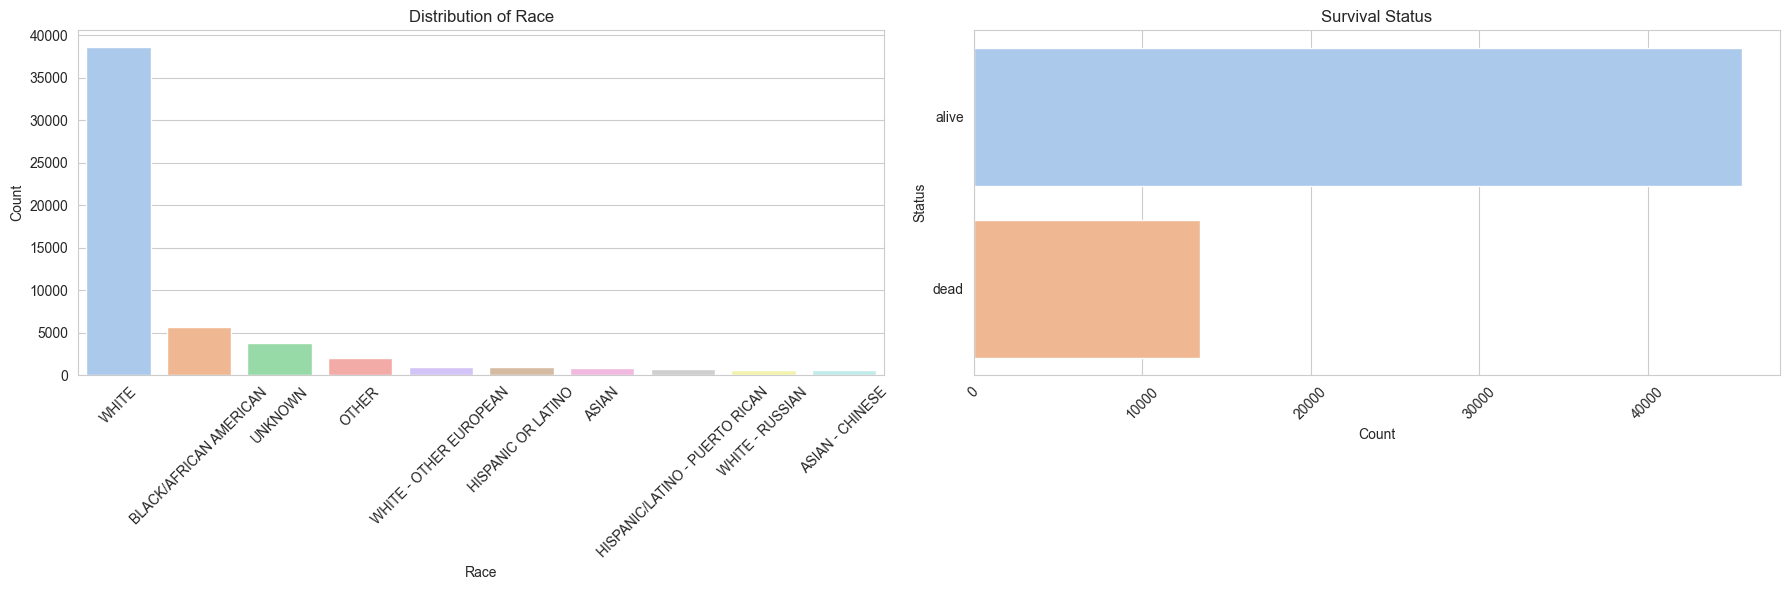

In [7]:
# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common)        
common_race = patients['race'].value_counts().head(10)                                              # For better visualization, as there are many categories

sns.barplot(data =common_race, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')
axes[1].set_title('Survival Status')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Now, lets see how many patients had a heart failure diagnosis 

In [ ]:

# Lets create a dataframe with the icd_codes and the icd guide
'''
We will fetch the ICD guide and the ICD data from the hosp module 
'''
icd_query_guide = '''
SELECT
icd_code,
icd_version,
long_title
FROM
    `physionet-data.mimiciv_hosp.d_icd_diagnoses`
'''

icd_query = '''
SELECT 
subject_id,
hadm_id,
icd_code,
icd_version,
seq_num
FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd`

'''
#Fetch the data as a DataFrame
icd_guide = client.query(icd_query_guide).to_dataframe(create_bqstorage_client=True)                # This df contains the ICD guide data (titles for every icd code)
icd = client.query(icd_query).to_dataframe(create_bqstorage_client=True)                            # This df contains the ICD data (icd codes for every patient)

# Display the first few rows of the DataFrames
print('\nICD guide data:')
print(icd_guide.head())

print('\nICD data:')
print(icd.head())

In [ ]:

# Lets merge the icd data with the icd guide data
'''
This will allow us to decipher the icd codes and see the different diagnosis for the patients with
more than one admission
'''
icd_merged = pd.merge(icd, icd_guide, on=['icd_code', 'icd_version'], how='inner')

# Save the merged ICD data to a CSV file so we can load it later without running the query again
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\icd_merged.csv'
icd_merged.to_csv(path, index=False)

#save the merged admissions_icd data to a CSV file

path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions_icd.csv'
admissions_icd.to_csv(path, index=False)


In [4]:
# Load the merged ICD data from the CSV file
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\icd_merged.csv'
icd_merged = pd.read_csv(path)
# Merge the admissions and icd data 
admissions_icd = pd.merge( admissions, icd_merged, on=['hadm_id'], how= 'left')

#save the merged admissions_icd data to a CSV file

path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions_icd.csv'
admissions_icd.to_csv(path, index=False)

In [10]:
# Now, lets drop the patients with congenital heart diseases, a pacemaker or an acute myocardial 
# infarction 

'''
These constitute the exclusion criteria for the analysis, as they might alter the ECG input that
will be used in the model. 

'''

diseases_to_exclude_icd_9 = ['745', '746', '747',                                                   # Congenital heart diseases                              
                             'V45',                                                                 # Pacemaker
                             '410']                                                                 # Acute myocardial infarction (during the hospitalization)           

# ICD-10 codes (as strings)
diseases_to_exclude_icd_10 = ['Q24',                                                                # Congenital heart diseases
                              'Z95',                                                                # Pacemaker                                
                              'I21', 'I22', 'I23']                                                  # Acute myocardial infarction (during the hospitalization)
diseases_to_exclude = diseases_to_exclude_icd_9 + diseases_to_exclude_icd_10
total_df_filtered = admissions_icd[~admissions_icd['icd_code'].apply(
    lambda x: isinstance(x, str) and any(x.startswith(code) for code in diseases_to_exclude)
)]

In [11]:
# Lets drop the patients that did not have a heart failure diagnosis
'''  
This will help us visualize the population we will be working with
'''

heart_failure_icd9 = [                                                                              # Heart failure ICD-9 codes                          
    '428', '4280', '4281', '4282', '42820', '42821', '42822', '42823', 
    '4283', '42830', '42831', '42832', '42833', '4284', '42840', '42841', 
    '42842', '42843', '4289', '40201', '40211', '40291', '40401', 
    '40403', '40411', '40413', '40491', '40493']

heart_failure_icd10 = [                                                                             # Heart failure ICD-10 codes
    'I50', 'I501', 'I502', 'I5020', 'I5021', 'I5022', 'I5023', 
    'I503', 'I5030', 'I5031', 'I5032', 'I5033', 'I504', 'I5040', 
    'I5041', 'I5042', 'I5043', 'I508', 'I5081', 'I50810', 'I50811', 
    'I50812', 'I50813', 'I50814', 'I5082', 'I5083', 'I5084', 'I5089', 
    'I509']

heart_failure_codes = heart_failure_icd9 + heart_failure_icd10
heart_failure_admissions = total_df_filtered[total_df_filtered['icd_code'].isin(heart_failure_codes)] 


# Lets visualize the data
heart_failure_admissions.head() 


,subject_id_x,hadm_id,admittime,dischtime,admission_type,admission_location,race,gender,anchor_year_group,anchor_year,anchor_age,dod,study_id,file_name,ecg_time,path,length_of_stay_(days),subject_id_y,icd_code,icd_version,seq_num,long_title
6,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,49164244.0,49164244.0,2147-05-09 11:06:00,files/p1010/p10106244/s49164244/49164244,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
31,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,44859244.0,44859244.0,2147-05-09 16:53:00,files/p1010/p10106244/s44859244/44859244,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
56,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,40600970.0,40600970.0,2147-05-10 08:17:00,files/p1010/p10106244/s40600970/40600970,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
81,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,48644999.0,48644999.0,2147-05-11 07:27:00,files/p1010/p10106244/s48644999/48644999,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
244,10433099,28593361,2148-12-24 20:41:00,2149-02-01 14:30:00,EW EMER.,EMERGENCY ROOM,BLACK/AFRICAN AMERICAN,M,2008 - 2010,2147,62,NaN,41790197.0,41790197.0,2148-12-27 13:25:00,files/p1043/p10433099/s41790197/41790197,38,10433099.0,4280,9.0,15.0,"Congestive heart failure, unspecified"


In [13]:
#Lets compute the encripted data to get the age of the patients 

# Convert the admittime to a datetime object
heart_failure_admissions['admittime'] = pd.to_datetime(heart_failure_admissions['admittime'])

# Extract the year from the admittime

heart_failure_admissions['age'] = heart_failure_admissions['admittime'].dt.year \
    - heart_failure_admissions['anchor_year'] + heart_failure_admissions['anchor_age']

HF_patients = heart_failure_admissions[heart_failure_admissions.\
    duplicated(subset='subject_id_x') == False]                                                     # Filter out the repeated patients for the demographic EDA
print(HF_patients.head())

# Calculate the age
HF_patients['age'] = HF_patients['admittime'].dt.year - HF_patients['anchor_year'] + HF_patients[
    'anchor_age']

      subject_id_x   hadm_id           admittime            dischtime  \
6         10106244  26713233 2147-05-09 10:34:00  2147-05-12 13:43:00   
244       10433099  28593361 2148-12-24 20:41:00  2149-02-01 14:30:00   
508       12862321  27343985 2190-09-25 13:53:00  2190-10-15 14:48:00   
609       13487953  23271164 2188-09-11 18:25:00  2188-09-21 18:14:00   
1142      10109432  21566054 2185-04-08 23:09:00  2185-04-12 18:31:00   

     admission_type  admission_location                    race gender  \
6      DIRECT EMER.  PHYSICIAN REFERRAL                   WHITE      F   
244        EW EMER.      EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      M   
508        EW EMER.      EMERGENCY ROOM                   ASIAN      F   
609        EW EMER.      EMERGENCY ROOM                   WHITE      M   
1142       EW EMER.      EMERGENCY ROOM                   OTHER      M   

     anchor_year_group  anchor_year  anchor_age         dod    study_id  \
6          2011 - 2013         2144      

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\1570585046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_failure_admissions['admittime'] = pd.to_datetime(heart_failure_admissions['admittime'])
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\1570585046.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_failure_admissions['age'] = heart_failure_admissions['admittime'].dt.year \
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\1570585046.py:15: SettingWithCopyWarnin

In [14]:
# Lets count the amount of unique patients with at least one ECG and how many are dead or alive
unique_count = heart_failure_admissions['subject_id_x'].nunique()
dead_counts = HF_patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, that have an ECG and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')


There are 17898 unique patients in the admissions data, that have an ECG and:
7917 are dead.
9981 are alive.


There are 17898 unique patients in the admissions data, that have a HF diagnosis    and at least one ECG per admission
7917 are dead.
9981 are alive.


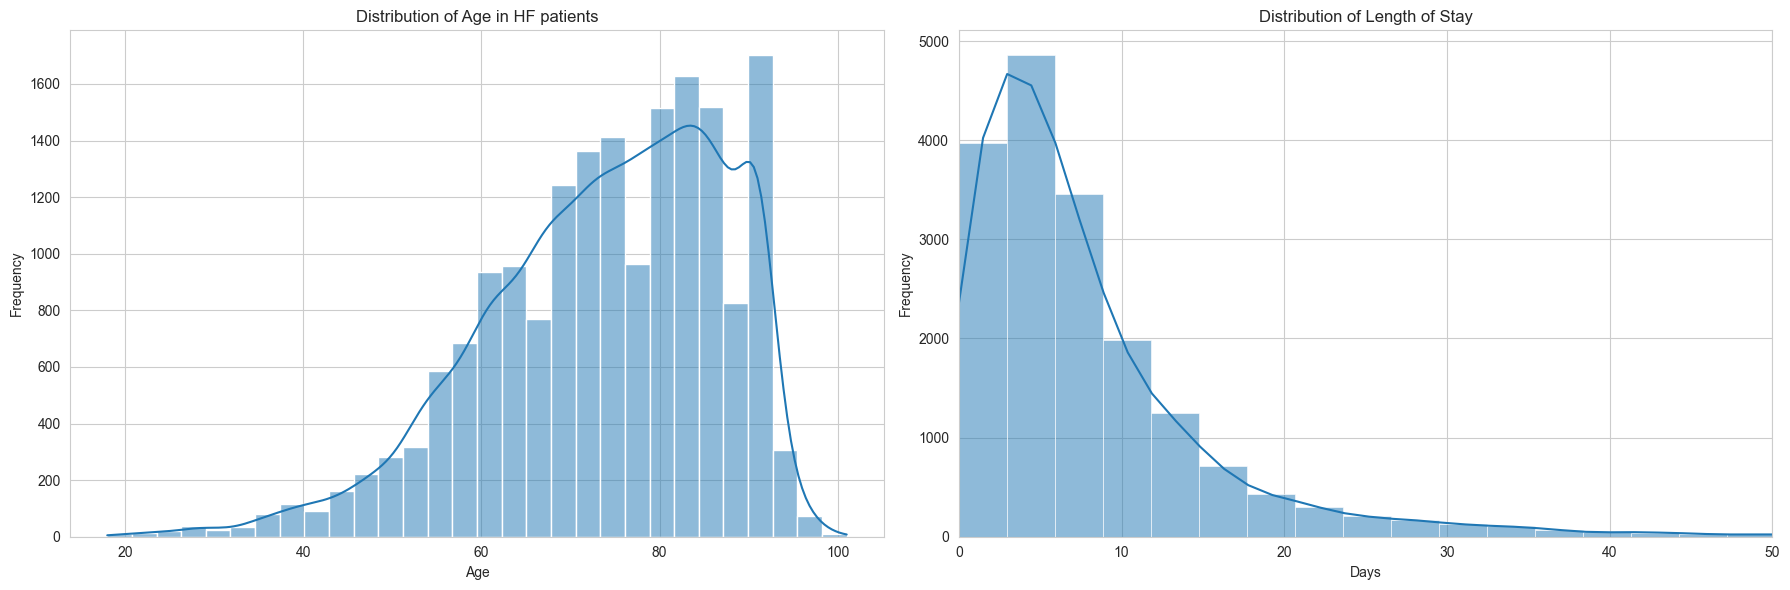

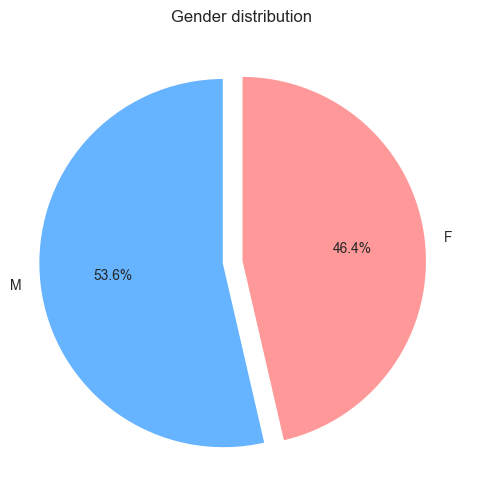

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\3423435554.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='pastel')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\3423435554.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_14788\3423435554.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')


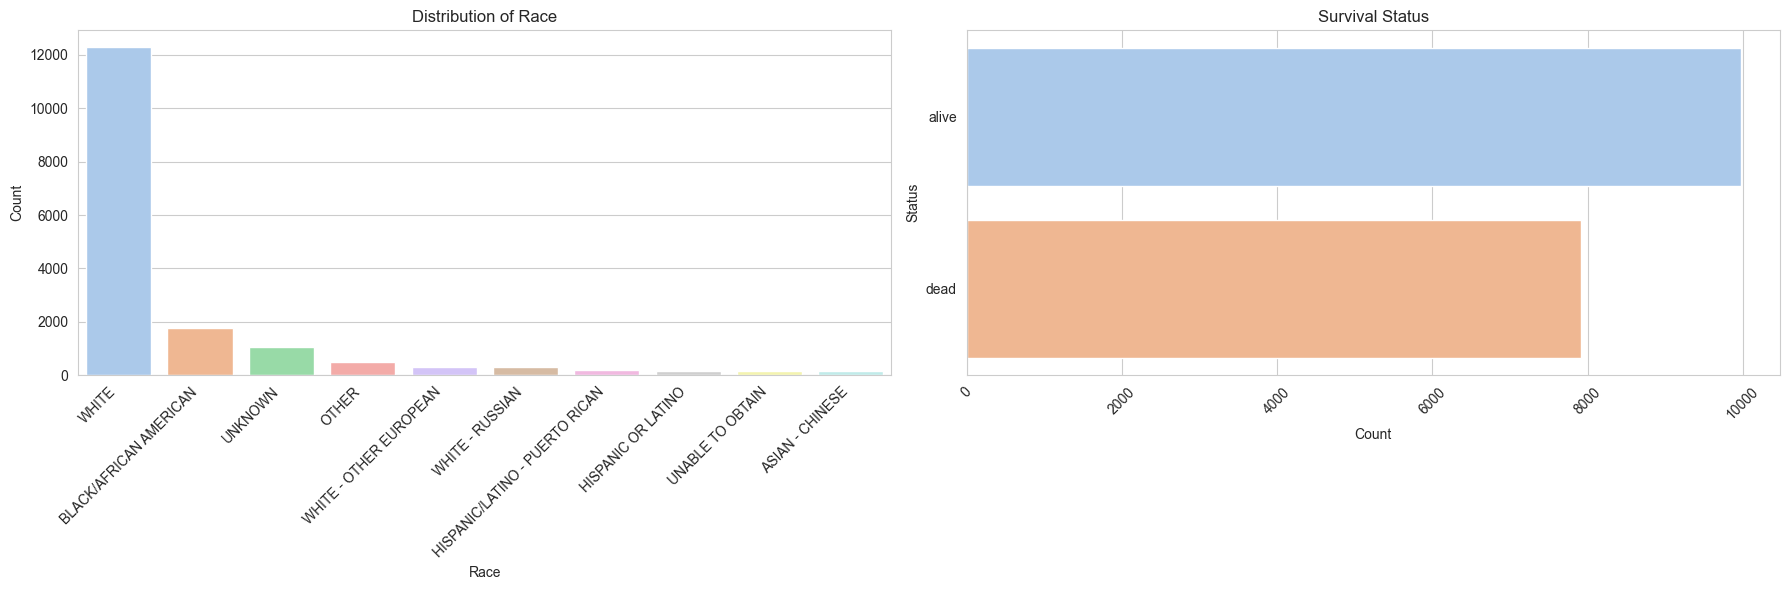

In [15]:
# Lets visualize the demographic data (patients that have at least one admission)

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(HF_patients['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age in HF patients')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(HF_patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Now lets plot the gender distribution

plt.figure(figsize=(6, 6))
HF_patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
shadow=False, colors=['#66b3ff', '#ff9999'])
plt.title('Gender distribution')
plt.ylabel('')
plt.show()

# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common)
common_race = HF_patients['race'].value_counts().head(10).dropna()

sns.barplot(data =common_race, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')
axes[1].set_title('Survival Status')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [16]:
# Shapiro test for normality of the age feature in the heart failure population


stat, p = shapiro(HF_patients['age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret the test
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian ')
else:
    print('Sample does not look Gaussian ')
    
HF_patients['age'].median()

Statistics=0.957, p=0.000
Sample does not look Gaussian 


c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17898.
  res = hypotest_fun_out(*samples, **kwds)


76.0

# Separate the data for each analysis 

We will create two separate datasets for the mortality and hospitalization analysis.

In [ ]:
#  For the mortality analysis
'''
We only need the last hospitalization of the patients, the one before they died.
'''
# Sort the data by subject_id and dod

mortality_analysis = heart_failure_admissions.sort_values(by=['subject_id_x', 'dod', 'admittime'],  # Put the most recent hospitalizations last.
                                                          ascending=[True, False, False])
mortality_analysis = mortality_analysis.drop_duplicates(subset='subject_id_x', keep='first')        # Keep the last hospitalization of each patient

mortality_analysis.head()


In [ ]:

# Hospitalization analysis
'''
we will drop the patients that died within the first year of the last hospitalization,
and we will only keep the first hospitalization of the patients that are still alive.
'''
# Convert 'dod' and 'admittime' to datetime
heart_failure_admissions['dod'] = pd.to_datetime(heart_failure_admissions['dod'], errors='coerce')
heart_failure_admissions['admittime'] = pd.to_datetime(heart_failure_admissions['admittime'])

hospitalization_analysis = heart_failure_admissions.sort_values(by=['subject_id_x', 'dod',          
                                                                    'admittime'], 
                                                                ascending=[True, False, False])
hospitalization_analysis = hospitalization_analysis.drop_duplicates(subset='subject_id_x',         
                                                                    keep='last')


# Filter patients who are either still alive or died more than 365 days after their last admission
hospitalization_analysis = hospitalization_analysis[hospitalization_analysis['dod'].isna() | 
                                                    ((hospitalization_analysis['dod'] - 
                                                     hospitalization_analysis['admittime']).dt.days > 365)]

hospitalization_analysis.head()



In [18]:
# Lets save the mortality_analysis and the hospitalization analysis as a csv

# Save the admissions data to a CSV file

path_mort = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\mortality_analysis.csv'
path_hosp = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\hosp_analysis.csv'
mortality_analysis.to_csv(path_mort, index=False)
hospitalization_analysis.to_csv(path_hosp, index=False)

# Conclusions

1. Patient Demographics:

- Age Distribution:
        In the general dataset, patients cover a broad age range, but the mean age is 58 years. However, in the heart failure (HF) cohort, the median age is significantly higher at 65 years, reflecting the fact that heart failure predominantly affects older adults.
        A statistical test (Shapiro-Wilks) confirmed that the age distribution is non-Gaussian, meaning it is skewed or has outliers, particularly in older populations. This suggests that age is not uniformly distributed.
        The age distribution visualization shows a peak around the 60–80 age group, which is typical of chronic cardiovascular conditions like heart failure.
- Gender Distribution:
        The general dataset shows an approximately even split between male and female patients. This balance holds across various subgroups, including those with ECG data.
        In the heart failure population, visualizations showed a slight male dominance.
- Race Distribution:
        The racial distribution is primarily White and Black/African American, consistent with the hospital’s patient demographics. There is a smaller representation of other races like Asian and Hispanic, likely reflecting the local population served by the hospital, more studies will be needed for minorities.


2. Length of Stay:

General Population:
        The median length of hospital stay is around 3-7 days, with some outliers showing much longer stays (e.g., up to 50 days). These extended stays may represent patients with more severe health issues or complications, particularly those with multiple chronic conditions.
Heart Failure Cohort:
        In the HF subset, length of stay varies widely, with a median closer to 10 days. This longer duration reflects the complexity of heart failure management, where patients often need extended monitoring, interventions, or rehabilitation.
        Outliers in this group (patients staying up to 50+ days) may represent recurrent hospitalizations, end-stage heart failure, or those undergoing more complex treatment protocols (e.g., waiting for a heart transplant or pacemaker).

3. Mortality and Survival Analysis:

General Population:
        In the general admissions data, a large proportion of patients are still alive, reflecting that the dataset includes many patients with acute but treatable conditions. However, in the heart failure subset, mortality rates are significantly higher, which is expected given the chronic and often progressive nature of heart failure.
Heart Failure Population:
        Out of 17,898 HF patients with at least one ECG, 7,917 (44%) had died at the time of data collection. This high mortality rate indicates that the dataset includes a significant portion of patients with advanced heart failure, where prognosis is often poor.
        Mortality is particularly high among patients over 75 years and those with longer hospital stays, further supporting the role of these factors as potential predictors in mortality risk models.
        A specific analysis was conducted on patients' last hospitalization before death, allowing for targeted research into end-of-life care or factors leading to in-hospital mortality.
        Additionally, patients who survived beyond the first year after their last hospitalization could be analyzed separately for long-term survival predictors.

4. Heart Failure Diagnosis Filtering:

    ICD Code Filtering:
        Heart failure patients were identified using ICD-9 and ICD-10 codes specific to heart failure, excluding those with unrelated diagnoses like congenital heart disease, pacemaker implantation, or acute myocardial infarction (to avoid confounding factors).
        The filtered dataset provides a clean cohort for studying the progression of heart failure and its complications, making it suitable for developing models that predict hospital readmission, mortality, or the need for advanced therapies like left ventricular assist devices (LVADs) or heart transplants.
    Exclusions:
        Patients with diagnoses unrelated to chronic heart failure were excluded to focus the analysis on this specific patient group. This filtering ensures that the outcomes studied are primarily driven by heart failure progression and not by other comorbidities that could cloud the analysis.

5. ECG Data:
        Only patients with an ECG associated with their hospitalization were included in this analysis. This ensures that the dataset is focused on patients for whom dynamic heart condition data is available, making it ideal for predictive modeling of cardiac outcomes.